In [172]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, roc_auc_score, f1_score, accuracy_score, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import tensorflow.keras as keras
import csv
import time

In [176]:
X = []
Y = []

with open('./new_data.csv', newline='') as csfile:
    spamreader = csv.reader(csfile, delimiter=' ', quotechar='|')
    for row in spamreader:
        X.append(row[0])
        Y.append(int(row[1]))

In [177]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=0)

In [ ]:
def get_points(list_kp):
    res = []
    for kp in list_kp:
        m = len(kp)
        points = np.zeros((m, 2))
        for i in np.arange(m):
            points[i] = np.array(kp[i].pt)

        res.append(points)

    return res

In [ ]:
def get_key_point(list_kp, list_des):
    res = []
    for kp, des in zip(list_kp, list_des):
        kmeans = KMeans(n_clusters=2, random_state=0).fit(des)
        labels = kmeans.labels_
        kp_array = np.array(kp)
        key = list(kp_array[labels == 1])
        res.append(key)
    return res

In [5]:
def compute_data(X, n=8):

    kaze = cv2.KAZE_create()
    m = len(X)
    X_res = np.zeros((m,n))
    i = 0
    for x in X:
        img = cv2.imread(x, 0)
        img = cv2.resize(img, (128, 128))
        kp, des = kaze.detectAndCompute(img, None)

        pt = [i.pt for i in kp]
        pt_arr = np.array(pt)
        if pt_arr.shape[0] < n:
            if len(pt) != 0:
                for j in range(pt_arr.shape[0]):
                    X_res[i,j] = 1 / pt_arr.shape[0]
        else:
            kmeans = KMeans(n_clusters=n, random_state=0).fit(pt_arr)
            list_masks = [ kmeans.labels_ == i for i in range(n)]

            j = 0
            for mask in list_masks:
                pt_mask = np.round(pt_arr[mask,:], 0).astype(np.int)
                hist = np.sum(img[pt_mask[:,0], pt_mask[:,1]]) / np.sum(mask)
                X_res[i,j] = hist
                j += 1
        i += 1

    return X_res

In [178]:
train = compute_data(X_train)

In [ ]:
def preparing(descriptors):

    res = []
    for item in descriptors:
        n_rows = item.shape[0]
        if n_rows < 128:
            arr = np.append(item[:128], np.zeros((128 - n_rows, 64)), axis=0)
        else:
            arr = item[:128]
        res.append(arr)

    return res

In [ ]:
list_kp, list_des = compute_descriptors(X_train)
for i in range(len(list_des)):
    t = np.sum(list_des[i] == None)
    if t == 1:
        list_des[i] = np.zeros((64, 64))
print(np.mean([i.shape[0] for i in list_des]))


In [ ]:
def get_train_date(list_kp, n=8):
    m = len(list_kp)
    X_train = np.zeros((m, n))
    kmeans = KMeans(n_clusters=n, random_state=0)
    for i in np.arange(m):
        if len(list_kp[i]) < n:
            X[i] = np.ones((1,n)) if len(list_kp[i]) != 0 else np.zeros((1,n))
        else:
            kmeans.fit(list_kp[i])
            histogram = np.histogram(kmeans.labels_, bins=n)
            X_train[i] = histogram[0] / np.sum(histogram[0])
    return X_train

In [ ]:
key_points = get_key_point(list_kp, list_des)

In [ ]:
list_points = get_points(list_kp)
train = get_train_date(list_points, n=16)

In [ ]:
def create_datsets (key_points):
    max_number_key_points = np.max([len(i) for i in key_points])
    n_sample = len(key_points)
    res = np.zeros((n_sample, max_number_key_points, 2))
    for i in range(n_sample):
        for j in range(len(key_points[i])):
            res[i,j] = np.array(key_points[i][j].pt)

    for kp, des in zip(list_kp, list_des):
        kmeans = KMeans(n_clusters=2, random_state=0).fit(des)
        labels = kmeans.labels_
        kp_array = np.array(kp)
        key = list(kp_array[labels == 1])
        res.append(key)
    return res

In [ ]:
train = create_datsets(key_points)
#train = preparing(list_des)

In [4]:
kaze = cv2.KAZE_create()
img = cv2.imread('./img/001.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

img = cv2.resize(img, (128, 128))
gray = cv2.resize(gray, (128, 128))
s = time.time()
kp, des = kaze.detectAndCompute(gray, None)
print(time.time() - s)

0.016077756881713867


In [6]:
class_id = [i.class_id for i in kp]
pt = [i.pt for i in kp]
my_pt = [(i.angle, i.size) for i in kp]

In [7]:
pt_arr = np.array(pt)

In [8]:
mask = np.array(class_id) == 1

In [9]:
kmeans = KMeans(n_clusters=8, random_state=0)
kmeans.fit(pt_arr)
labels = kmeans.labels_
histogram = np.histogram(labels, bins=8)

In [12]:
kp_array = np.array(kp)
key = kp_array[labels == 1]
key = list(key)

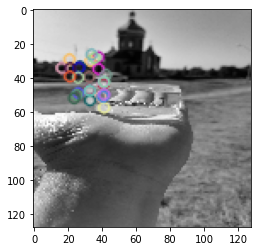

In [13]:
img_kp = cv2.drawKeypoints(gray, key, img)
plt.imshow(img_kp)

In [184]:
def model():
    key_points = keras.layers.Input(shape=(1,8), dtype='float32')
    X = keras.layers.BatchNormalization()(key_points)
    X = keras.layers.LSTM(32, return_sequences=True)(X)
    X = keras.layers.Dropout(rate=0.5)(X)
    X = keras.layers.LSTM(64, return_sequences=True)(X)
    X = keras.layers.Dropout(rate=0.5)(X)
    X = keras.layers.LSTM(128, return_sequences=True)(X)
    X = keras.layers.Dropout(rate=0.5)(X)
    X = keras.layers.LSTM(256, return_sequences=False)(X)
    X = keras.layers.Dropout(rate=0.5)(X)
    X = keras.layers.Dense(units=2)(X)
    X = keras.layers.Activation(activation='softmax')(X)

    model = keras.Model(inputs=key_points, outputs=X)

    return model

In [185]:
model = model()
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 8)]            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1, 8)              32        
_________________________________________________________________
lstm (LSTM)                  (None, 1, 32)             5248      
_________________________________________________________________
dropout (Dropout)            (None, 1, 32)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 64)             24832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 64)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 128)           

In [186]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [187]:
X_train_ar = train[:, np.newaxis,:]
Y_train_ar = np.zeros((len(Y_train), 2))

for i in range(len(Y_train)):
    Y_train_ar[i, Y[i]] = 1

In [188]:
model.fit(X_train_ar, Y_train_ar, epochs=52, batch_size=64, shuffle=True)

Epoch 1/52
1/1 [==============================] - 0s 1ms/step - loss: 0.6931 - accuracy: 0.5556
Epoch 2/52
1/1 [==============================] - 0s 990us/step - loss: 0.6897 - accuracy: 0.8730
Epoch 3/52
1/1 [==============================] - 0s 918us/step - loss: 0.6863 - accuracy: 0.8730
Epoch 4/52
1/1 [==============================] - 0s 3ms/step - loss: 0.6825 - accuracy: 0.8730
Epoch 5/52
1/1 [==============================] - 0s 2ms/step - loss: 0.6790 - accuracy: 0.8730
Epoch 6/52
1/1 [==============================] - 0s 2ms/step - loss: 0.6746 - accuracy: 0.8730

In [191]:
test = compute_data(X_test)

SystemError: <built-in function imread> returned NULL without setting an error

In [192]:
X_test_ar = test[:,np.newaxis, :]

In [193]:
y_pred = model.predict(X_test_ar)
y_pred_target = np.argmax(y_pred, axis=1)
y_pred_probability = np.max(y_pred, axis=1)

In [194]:
y_target = np.array(Y_test)
recall = recall_score(y_target, y_pred_target)
precission = precision_score(y_target, y_pred_target)
f1 = f1_score(y_target, y_pred_target)

Y_test_ar = np.zeros((len(test), 2))
for i in range(len(test)):
    Y_test_ar[i, Y_test[i]] = 1
roc_auc = roc_auc_score(Y_test_ar, y_pred)

In [195]:
print(f'accuracy: {accuracy_score(y_target, y_pred_target)}')
print(f'recall: {recall}')
print(f'precission: {precission}')
print(f'f1: {f1}')
print(f'roc_auc: {roc_auc}')

accuracy: 0.4883720930232558
recall: 1.0
precission: 0.4883720930232558
f1: 0.65625
roc_auc: 0.7467532467532467


In [197]:
print(f'accuracy: {accuracy_score(y_target, y_pred_target)}')
print(f'confusion_matrix: \n{confusion_matrix(y_target, y_pred_target)}')
print(f'roc_auc: {roc_auc}')

accuracy: 0.4883720930232558
confusion_matrix: 
[[ 0 22]
 [ 0 21]]
roc_auc: 0.7467532467532467


In [203]:
def compute_hist(frame, n=8):
    kaze = cv2.KAZE_create()
    m = 1
    X_res = np.zeros((m,n))

    img = cv2.resize(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY), (128, 128))
    kp, des = kaze.detectAndCompute(img, None)

    pt = [i.pt for i in kp]
    pt_arr = np.array(pt)

    if pt_arr.shape[0] < n:
        if len(pt) != 0:
            for j in range(pt_arr.shape[0]):
                X_res[0,j] = 1 / pt_arr.shape[0]
    else:
        kmeans = KMeans(n_clusters=n, random_state=0).fit(pt_arr)
        list_masks = [ kmeans.labels_ == i for i in range(n)]

        j = 0
        for mask in list_masks:
            pt_mask = np.round(pt_arr[mask,:], 0).astype(np.int)
            hist = np.sum(img[pt_mask[:,0], pt_mask[:,1]]) / np.sum(mask)
            X_res[0,j] = hist
            j += 1

    return X_res

In [204]:
cap = cv2.VideoCapture('test.mp4')

# Check if camera opened successfully
if (cap.isOpened() == False):
  print("Unable to read camera feed")

# Default resolutions of the frame are obtained.The default resolutions are system dependent.
# We convert the resolutions from float to integer.
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

# Define the codec and create VideoWriter object.The output is stored in 'outpy.avi' file.
out = cv2.VideoWriter('outpy.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (frame_width,frame_height))

while(True):
  ret, frame = cap.read()

  if ret == True:
    X = compute_hist(frame)[np.newaxis, :, :]
    class_object = np.argmax(model.predict(X))
    position = (25, 350)
    cv2.putText(frame, 'Class ' + str(class_object), position, cv2.FONT_HERSHEY_SIMPLEX, 8, (209, 80, 0, 255), 3)
    out.write(frame)

  else:
    break

# When everything done, release the video capture and video write objects
cap.release()
out.release()

# Closes all the frames
cv2.destroyAllWindows()

In [ ]:
## X_train

In [ ]:
y_pred = model.predict(X_train_ar)
y_pred_tar = np.argmax(y_pred, axis=1)

In [ ]:
y_target = np.array(Y_train)
recall = recall_score(y_target, y_pred_tar)
precission = precision_score(y_target, y_pred_tar)
f1 = f1_score(y_target, y_pred_tar)
#roc_auc = roc_auc_score(y_target, y_pred)

In [ ]:
print(f'recall: {recall}')
print(f'precission: {precission}')
print(f'f1: {f1}')
print(f'roc_auc: {roc_auc}')

In [ ]:
print(f'con_mat: {confusion_matrix(y_target, y_pred_tar)}')

In [ ]:
'''
model_json = model.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)

model.save_weights('model.h5')
'''

## SVM Linear

In [16]:
linear_SVM = LinearSVC(penalty='l2', loss='squared_hinge', dual=False, C=10**6)
scaler = StandardScaler()
X_train_arr = scaler.fit_transform(train)
Y_train_arr = np.array(Y_train)
linear_SVM.fit(X_train_arr, Y_train_arr)

LinearSVC(C=1000000, dual=False)

In [ ]:
list_kp_test, list_des_test = compute_descriptors(X_test)
for i in range(len(list_des_test)):
    t = np.sum(list_des_test[i] == None)
    if t == 1:
        list_des_test[i] = np.zeros((64, 64))

list_points_test = get_points(list_kp_test)
test = scaler.transform(get_train_date(list_points_test, n=16))

In [17]:
y_pred = linear_SVM.predict(test)

In [18]:
y_target = np.array(Y_test)

In [19]:
accuracy = accuracy_score(y_target, y_pred)
conf_matrix = confusion_matrix(y_target, y_pred)

In [20]:
print(f'accuracy: {accuracy}')
print(f'confusion matrix: \n {conf_matrix}')

accuracy: 0.4418604651162791
confusion matrix: 
 [[15 10]
 [14  4]]


## SVC

In [ ]:
svc = SVC(kernel='sigmoid', coef0=10**-6, C=10**6, gamma='auto')
X_train_arr = scaler.fit_transform(train)
Y_train_arr = np.array(Y_train)
svc.fit(X_train_arr, Y_train_arr)

In [ ]:
list_kp_test, list_des_test = compute_descriptors(X_test)
for i in range(len(list_des_test)):
    t = np.sum(list_des_test[i] == None)
    if t == 1:
        list_des_test[i] = np.zeros((64, 64))

list_points_test = get_points(list_kp_test)
test = scaler.transform(get_train_date(list_points_test, n=16))

In [ ]:
y_pred = svc.predict(test)
y_target = np.array(Y_test)

accuracy = accuracy_score(y_target, y_pred)
conf_matrix = confusion_matrix(y_target, y_pred)

In [ ]:
print(f'accuracy: {accuracy}')
print(f'confusion matrix: \n {conf_matrix}')

In [ ]:
y_pred = svc.predict(train)

y_target = np.array(Y_train)

accuracy = accuracy_score(y_target, y_pred)
conf_matrix = confusion_matrix(y_target, y_pred)

print(f'accuracy: {accuracy}')
print(f'confusion matrix: \n {conf_matrix}')

## NuSVC

In [15]:
nusvc = NuSVC(nu=0.5, kernel='sigmoid', coef0=10**-6)
X_train_arr = scaler.fit_transform(train)
Y_train_arr = np.array(Y_train)
nusvc.fit(X_train_arr, Y_train_arr)

NameError: name 'scaler' is not defined

In [ ]:
list_kp_test, list_des_test = compute_descriptors(X_test)
for i in range(len(list_des_test)):
    t = np.sum(list_des_test[i] == None)
    if t == 1:
        list_des_test[i] = np.zeros((64, 64))

list_points_test = get_points(list_kp_test)
test = scaler.transform(get_train_date(list_points_test))

In [ ]:
y_pred = nusvc.predict(test)
y_target = np.array(Y_test)

accuracy = accuracy_score(y_target, y_pred)
conf_matrix = confusion_matrix(y_target, y_pred)

In [ ]:
print(f'accuracy: {accuracy}')
print(f'confusion matrix: \n {conf_matrix}')

In [ ]:
y_pred = nusvc.predict(train)

y_target = np.array(Y_train)

accuracy = accuracy_score(y_target, y_pred)
conf_matrix = confusion_matrix(y_target, y_pred)

print(f'accuracy: {accuracy}')
print(f'confusion matrix: \n {conf_matrix}')

# Decission Tree

In [179]:
tree = DecisionTreeClassifier(max_depth=15, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_leaf_nodes=35)

In [180]:
X_train = scaler.fit_transform(train)
y_train = np.array(Y_train)
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=15, max_leaf_nodes=35)

In [181]:
test = compute_data(X_test)

In [182]:
X_test = scaler.transform(test)
y_pred = tree.predict(X_test)
y_target = np.array(Y_test)

accuracy = accuracy_score(y_target, y_pred)
conf_matrix = confusion_matrix(y_target, y_pred)
recall = recall_score(y_target, y_pred)
precission = precision_score(y_target, y_pred)

In [183]:
print('Test')
print(f'accuracy: {accuracy}')
print(f'confusion matrix: \n {conf_matrix}')
print(f'recall: {recall}')
print(f'precission: {precission}')

Test
accuracy: 0.627906976744186
confusion matrix: 
 [[11 11]
 [ 5 16]]
recall: 0.7619047619047619
precission: 0.5925925925925926


In [129]:
y_pred = tree.predict(train)
y_target = np.array(Y_train)

accuracy = accuracy_score(y_target, y_pred)
conf_matrix = confusion_matrix(y_target, y_pred)
recall = recall_score(y_target, y_pred)
precission = precision_score(y_target, y_pred)

In [92]:
print('Train')
print(f'accuracy: {accuracy}')
print(f'confusion matrix: \n {conf_matrix}')
print(f'recall: {recall}')
print(f'precission: {precission}')

Train
accuracy: 0.9941520467836257
confusion matrix: 
 [[90  0]
 [ 1 80]]
recall: 0.9876543209876543
precission: 1.0


# Random Forest

In [142]:
forest = RandomForestClassifier(n_estimators=1000, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_leaf_nodes=35)
forest.fit(train, y_train)

RandomForestClassifier(max_leaf_nodes=35, n_estimators=1000)

In [143]:
y_pred = forest.predict(test)
y_target = np.array(Y_test)

accuracy = accuracy_score(y_target, y_pred)
conf_matrix = confusion_matrix(y_target, y_pred)
recall = recall_score(y_target, y_pred)
precission = precision_score(y_target, y_pred)

In [144]:
print('Test')
print(f'accuracy: {accuracy}')
print(f'confusion matrix: \n {conf_matrix}')
print(f'recall: {recall}')
print(f'precission: {precission}')

Test
accuracy: 0.5348837209302325
confusion matrix: 
 [[14 11]
 [ 9  9]]
recall: 0.5
precission: 0.45


In [53]:
y_pred = forest.predict(train)
y_target = np.array(Y_train)

accuracy = accuracy_score(y_target, y_pred)
conf_matrix = confusion_matrix(y_target, y_pred)
recall = recall_score(y_target, y_pred)
precission = precision_score(y_target, y_pred)

In [54]:
print('Train')
print(f'accuracy: {accuracy}')
print(f'confusion matrix: \n {conf_matrix}')
print(f'recall: {recall}')
print(f'precission: {precission}')

Train
accuracy: 0.9941520467836257
confusion matrix: 
 [[89  1]
 [ 0 81]]
recall: 1.0
precission: 0.9878048780487805
